# Предсказание покупок

## 0. Описание проекта

### 0.1. Общее описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

### 0.2. Задачи, цели, ожидаемый результат

**Задачи**
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и метрику roc_auc
- Выполнить тестирование

**Цель**

- Предсказать вероятность покупки в течение 90 дней

### 0.3. Описание данных

**apparel-purchases**

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как
обработать такие случаи – можете предлагать свои варианты решения.

- client_id - идентификатор клиента
- quantity - количество единиц товара
- price - цена товара
- category_ids - идентификаторы категорий
- date дата - покупки
- message_id - идентификатор сообщения из рассылки

**apparel-messages**

Рассылки, которые были отправлены клиентам из таблицы покупок.

- bulk_campaign_id - идентификатор рассылки
- client_id - идентификатор клиента
- message_id - идентификатор сообщения
- event - действие с сообщением (отправлено, открыто, покупка…)
- channel - канал рассылки
- date - дата действия
- created_at - дата-время полностью

**target**

- client_id - идентификатор клиента
- target - клиент совершил покупку в целевом периоде

## 1. Загрузка данных и общая информация

In [6]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

from datetime import datetime
from catboost import CatBoostClassifier
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier
from scipy import stats as st
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import ast
import phik
import shap
import os
from typing import List, Tuple, Optional, Any, Dict, Union
import re
from urllib.request import urlretrieve
from zipfile import Path
import zipfile

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
TEST_SIZE = 0.25

### 1.1. Чтение данных

In [8]:
# Скачаем архив, распакуем, определим датасеты и папки с фото

url = "https://huggingface.co/datasets/onejetpilot/purchases/resolve/main/filtered_data.zip"

zip_path = "filtered_data.zip"

pth_messages = "filtered_data/apparel-messages.csv"
pth_purchases = "filtered_data/apparel-purchases.csv"
pth_target_binary = "filtered_data/apparel-target_binary.csv"


if not os.path.exists(zip_path):
    print("Скачиваю архив...")
    urlretrieve(url, zip_path)
    print("Архив скачан:", zip_path)
else:
    print("Архив уже есть:", zip_path)

need_extract = not all([
    os.path.exists(pth_messages),
    os.path.exists(pth_purchases),
    os.path.exists(pth_target_binary)
])

if need_extract:
    print("Распаковываю архив в:", zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(".")
    print("Готово.")
else:
    print("Файлы уже распакованы - пропускаю распаковку.")

if os.path.exists(pth_messages):
    messages = pd.read_csv(pth_messages)
    purchases = pd.read_csv(pth_purchases)
    target = pd.read_csv(pth_target_binary)

    print("Данные загружены:")
    print(" - messages:", messages.shape)
    print(" - purchases:", purchases.shape)
    print(" - target:", target.shape)

else:
    print("Файлы не найдены после распаковки - проверьте содержимое архива.")

Скачиваю архив...
Архив скачан: filtered_data.zip
Распаковываю архив в: filtered_data.zip
Готово.
Данные загружены:
 - messages: (12739798, 7)
 - purchases: (202208, 6)
 - target: (49849, 2)


In [9]:
# Посмотрим на получившиеся датасет

messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [10]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [11]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


### 1.2. Изучение общей информации о датасете

In [12]:
def overview_data(data):
    """
    Выводит информацию о DataFrame - типы данных, 
    количество пропусков и дубликатов

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, для которой требуется провести обзор

    Возвращает
    ----------
    None
        Функция выводит информацию
    """
    
    
    d = '-' * 50
    
    print(d)
    print('Инфо')
    print(d)
    print(data.info())
    print('\n')
    
    print(d)
    print('Пропуски')
    print(d)
    print(data.isna().sum())
    print('\n')
    
    print(d)
    print('Дубликаты')
    print(d)
    print(data.duplicated().sum())
    print('\n')

In [13]:
# Выведем общую информацию о датасете

overview_data(messages)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None


--------------------------------------------------
Пропуски
--------------------------------------------------
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


--------------------------------------------------
Дубликаты
--------------------------------------------------
48610




In [14]:
# Выведем общую информацию о датасете

overview_data(purchases)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None


--------------------------------------------------
Пропуски
--------------------------------------------------
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


--------------------------------------------------
Дубликаты
--------------------------------------------------
73020




In [15]:
# Выведем общую информацию о датасете

overview_data(target)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None


--------------------------------------------------
Пропуски
--------------------------------------------------
client_id    0
target       0
dtype: int64


--------------------------------------------------
Дубликаты
--------------------------------------------------
0




В датасетах нет пропусков но много дубликатов, сразу их удалим.

In [16]:
# Удалим дубликаты

messages = messages.drop_duplicates()
purchases = purchases.drop_duplicates()

In [17]:
# Проверим размер получившегося датасета

print(messages.shape)
print(purchases.shape)
print(target.shape)

(12691188, 7)
(129188, 6)
(49849, 2)


In [18]:
# Объединим датасеты

data = purchases.merge(messages, on=['client_id', 'message_id'], how='left', suffixes=('_buy', '_msg'))  
data = data.merge(target, on='client_id', how='left')

Столбцы created_at и date_msg аналогичны, но в created_at есть еще время. Удалим столбец date_msg 

In [19]:
data= data.drop('date_msg', axis=1)

In [20]:
# Посмотрим что получилось

data.head()

,client_id,quantity,price,category_ids,date_buy,message_id,bulk_campaign_id,event,channel,created_at,target
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,NaN,NaN,NaN,NaN,0
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,NaN,NaN,NaN,NaN,0
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,NaN,NaN,NaN,NaN,0
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,NaN,NaN,NaN,NaN,0
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,NaN,NaN,NaN,NaN,0


In [21]:
# Выведем общую информацию о датасете

overview_data(data)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535950 entries, 0 to 535949
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         535950 non-null  int64  
 1   quantity          535950 non-null  int64  
 2   price             535950 non-null  float64
 3   category_ids      535950 non-null  object 
 4   date_buy          535950 non-null  object 
 5   message_id        535950 non-null  object 
 6   bulk_campaign_id  502125 non-null  float64
 7   event             502125 non-null  object 
 8   channel           502125 non-null  object 
 9   created_at        502125 non-null  object 
 10  target            535950 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 45.0+ MB
None


--------------------------------------------------
Пропуски
----------------------------

In [22]:
data.shape

(535950, 11)

In [23]:
# Преобразуем в datetime

data['created_at'] = pd.to_datetime(data['created_at'])
data['date_buy'] = pd.to_datetime(data['date_buy'])

In [24]:
# Описание числовых признаков датасета

data.describe()

,client_id,quantity,price,date_buy,bulk_campaign_id,created_at,target
count,535950.00,535950.00,535950.00,535950,502125.00,502125,535950.00
mean,1515915625578369024.00,1.01,1282.25,2023-02-02 04:15:54.196474112,9402.25,2023-01-29 12:45:16.373407488,0.04
min,1515915625468060928.00,1.00,1.00,2022-05-16 00:00:00,563.00,2022-05-19 01:50:17,0.00
25%,1515915625489080064.00,1.00,419.00,2022-08-07 00:00:00,5707.00,2022-08-03 10:59:31,0.00
50%,1515915625503764480.00,1.00,999.00,2022-12-30 00:00:00,8902.00,2022-12-23 14:55:07,0.00
75%,1515915625594340096.00,1.00,1799.00,2023-06-15 00:00:00,13324.00,2023-06-13 16:10:50,0.00
max,1515915626010443520.00,30.00,85499.00,2024-02-16 00:00:00,14657.00,2024-02-15 23:51:20,1.00
std,138523701.01,0.21,1364.37,NaN,3656.61,NaN,0.19


### Вывод

- Пропуски по столбцам bulk_campain_id, event, channel, created_at
- category_ids необходимо обработать, возможно разделить на несколько колонок
- дубликаты не обнаружены

## 2. Анализ и обработка данных

In [25]:
def num_diag(data, x, xlabel, ylabel, hue=None):
    """
    Визуализирует распределение числового признака с помощью гистограммы и boxplot

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, содержащая признак
    
    x : str
        Название числового признака, по которому строятся графики.

    xlabel : str
        Подпись оси X для графиков

    ylabel : str
        Подпись оси Y для графиков.=

    hue : str, optional
        Название категориального признака для разделения данных по цветам на гистограмме

    Возвращает
    ----------
    None
        Функция строит графики
    """
    
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat='density',
        bins=20,
        common_norm=False)
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    
    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1])
    axes[1].set_title(f'Гистограмма размаха по {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)
    
    plt.tight_layout()
    plt.show()

In [109]:
# Напишем функцию построения диаграмм для категориальных признаков
def cat_diag(data, x, xlabel, hue=None, threshold=0.015):
    """
    Строит диаграммы распределения для категориального признака: 
    countplot с группировкой и круговую диаграмму

    Малые категории по частоте объединяются в категорию "Другие"

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица с данными, содержащая категориальный признак

    x : str
        Название категориального признака, по которому строятся графики

    xlabel : str
        Подпись оси X на countplot

    hue : str, optional
        Название категориального признака для группировки по цветам на countplot

    threshold : float, optional
        Порог частоты (от 0 до 1), ниже которого категории объединяются в "Другие" 
        По умолчанию 0.015 (1.5%)

    Возвращает
    ----------
    None
        Функция строит графики
    """
        
        
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts<threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)
    
    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index)
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)
    
    pie_data = data_modified[x].value_counts(normalize=True)
    
    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False)
    axes[1].set_title('Распределение долей')
    axes[1].set_ylabel('')
    
    plt.tight_layout()

In [26]:
def date_diag(data, x, hue=None, figsize=(16, 6)):
    """
    Строит временную диаграмму (countplot) по дате.

    Преобразует datetime-признак в даты без времени и отображает 
    количество записей по каждой дате. Если нужно, можно применить 
    цветовую группировку по hue

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, содержащая временной признак

    x : str
        Название столбца с типом datetime

    hue : str, optional
        Название категориального признака для группировки по цветам

    figsize : tuple, optional
        Размер графика в формате (ширина, высота), по умолчанию (16, 6)

    Возвращает
    ----------
    None
        Функция строит график
    """
    
    
    data_modified = data.copy()
    data_modified['date'] = data_modified[x].dt.month
    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=data_modified,
        x='date',
        hue=hue,
        order=sorted(data_modified['date'].unique()))
        
    plt.title(f'Диаграмма по {x}')
    plt.xlabel('Дата')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [27]:
def all_diag(data, column_type='numeric', hue=None):
    """
    Автоматически визуализирует признаки заданного типа: числовые, категориальные или временные.

    В зависимости от типа признаков вызывает соответствующие функции визуализации 
    (num_diag, cat_diag, date_diag) для каждого подходящего столбца в DataFrame.

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных для анализа

    column_type : str, optional
        Тип признаков для визуализации. Возможные значения:
        - 'numeric' — числовые признаки
        - 'categorical' — категориальные признаки
        - 'date' или 'datetime' — временные признаки

    hue : str, optional
        Название столбца для цветовой группировки, если нужно

    Возвращает
    ----------
    None
         Функция строит график
    """     
    
    
    if column_type == 'numeric':
        columns = data.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = data.select_dtypes(include=['object', 'category']).columns
    elif column_type in ('date', 'datetime'):
        columns = data.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
        
    for col in columns:
        if column_type == 'numeric':
            print(f'Визуализация числового признака: {col}')
            num_diag(data, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f'Визуализация категориального признака {col}')
            cat_diag(data, x=col, xlabel=col, hue=hue)
        elif column_type == 'date':
            print(f'Визуализация верменного признака: {col}')
            date_diag(data, x=col, hue=hue)

In [28]:
data.head()

,client_id,quantity,price,category_ids,date_buy,message_id,bulk_campaign_id,event,channel,created_at,target
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,NaN,NaN,NaN,NaT,0
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,NaN,NaN,NaN,NaT,0
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,NaN,NaN,NaN,NaT,0
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,NaN,NaN,NaN,NaT,0
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,NaN,NaN,NaN,NaT,0


### 2.1. Анализ числовых признаков

Визуализация числового признака: client_id


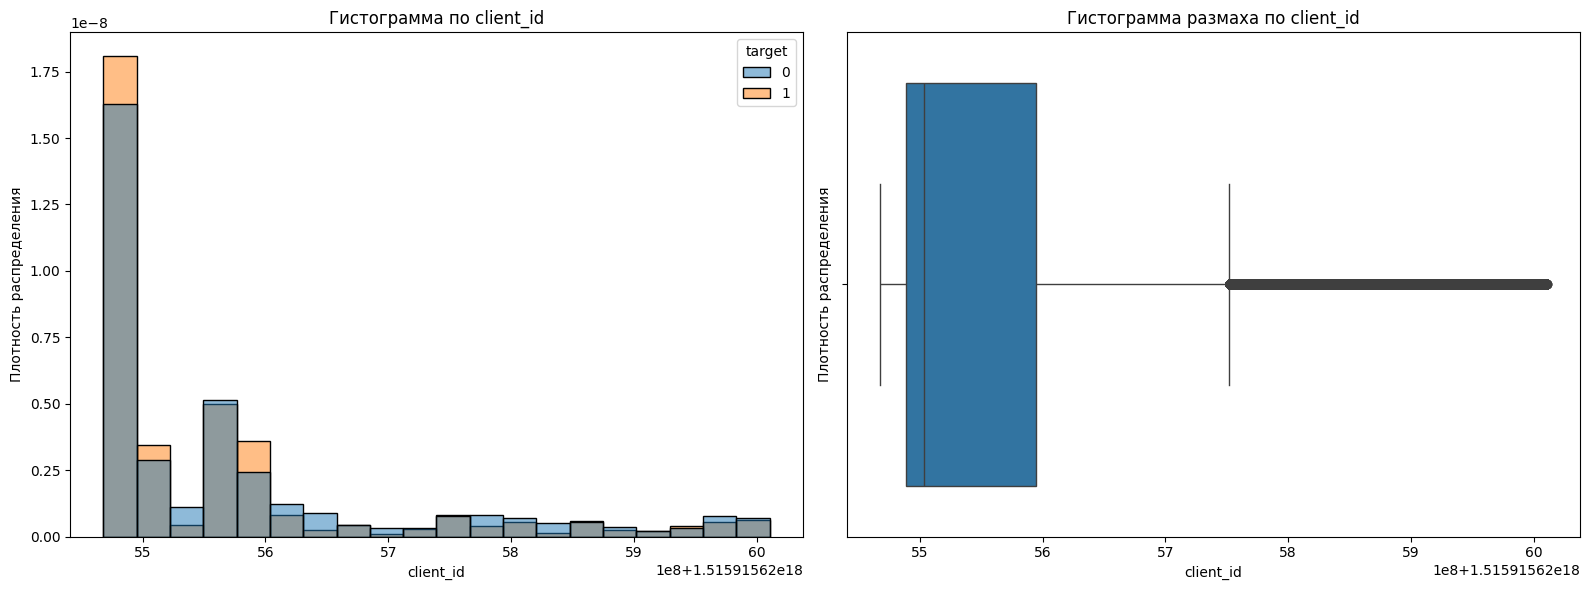

Визуализация числового признака: quantity


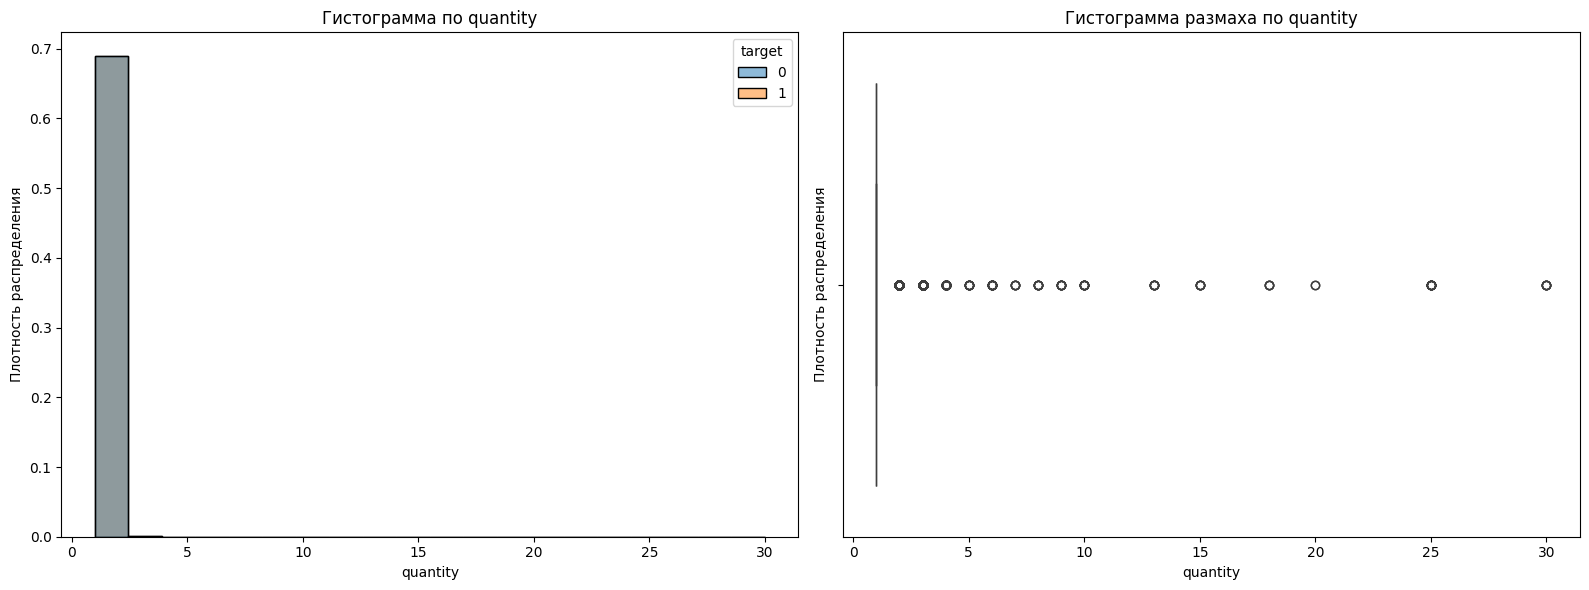

Визуализация числового признака: price


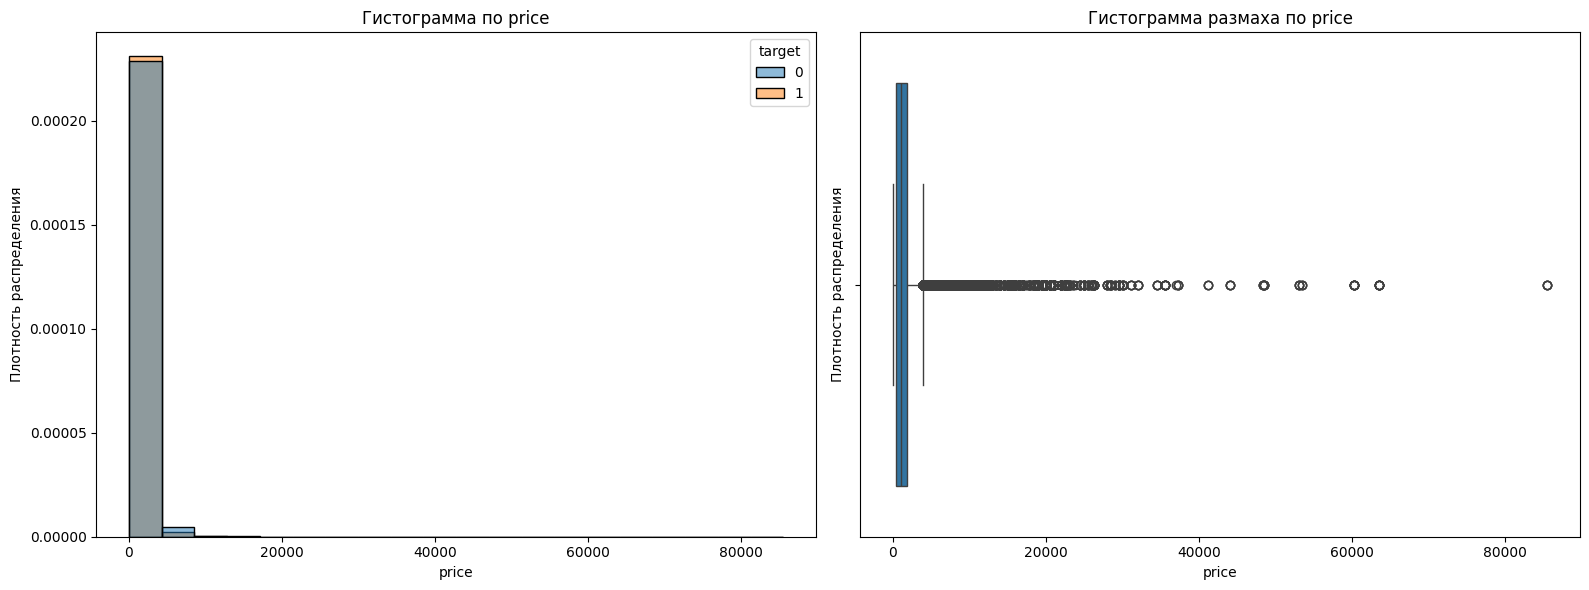

Визуализация числового признака: bulk_campaign_id


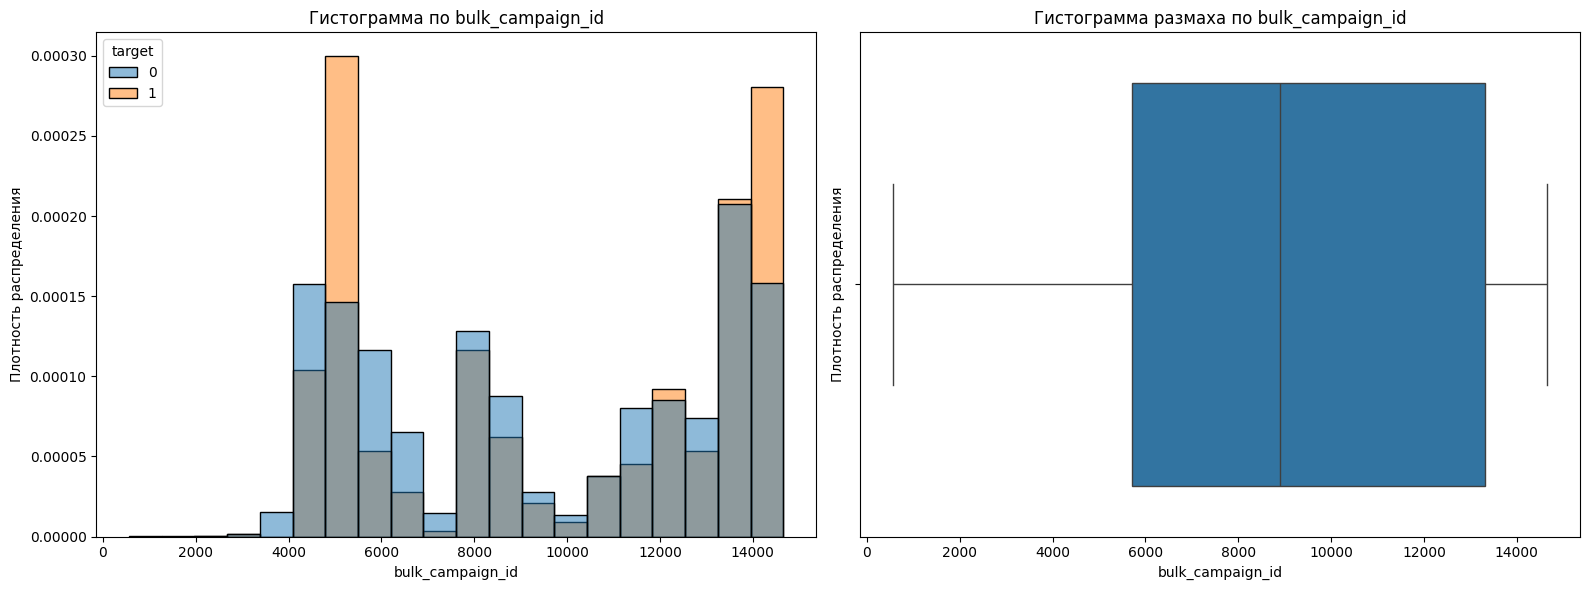

Визуализация числового признака: target


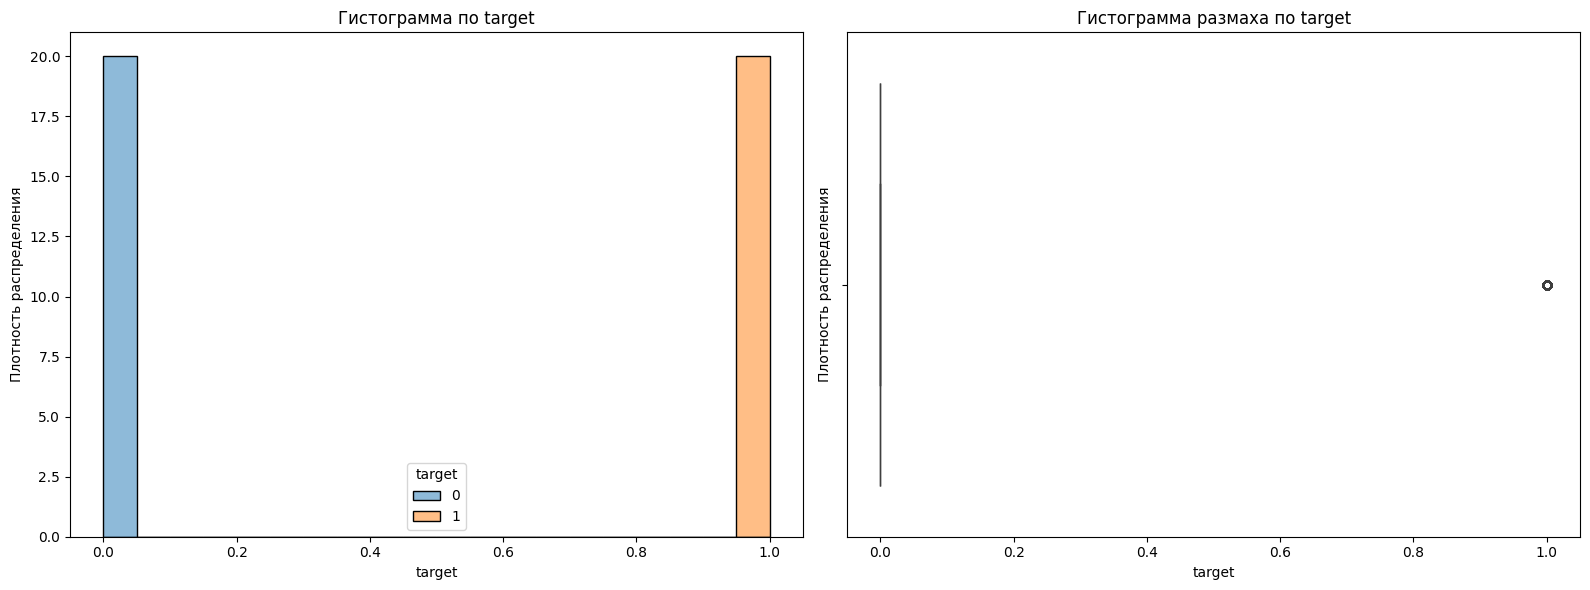

In [29]:
# Визуализируем числовые признаки

all_diag(data, column_type='numeric', hue='target')

Видим выбросы по цене и количеству, посмотрим сколько их и отфильтруем датасет. 

In [30]:
# Посмотрим сколько значений количества больше 1

(data['quantity']>1).sum()

4052

Значений меньше 1% от всего датасета, и т.к. у нас в столбце останется только одно значение после фильтрации - можем совсем удалить этот столбец.

In [31]:
# Посмотрим сколько значений цены больше 4000

(data['price']>4000).sum()

12981

In [32]:
# Посмотрим максимальное значение по количеству

(data['quantity']).max()

30

In [33]:
# Посмотрим максимальное значение по цене

(data['price']).max()

85499.0

In [34]:
# Отфильтруем датасет и удалим столбец quantity

data_fltr = data[(data['price'] <= 4000) & (data['quantity'] <= 1)]
data_fltr = data_fltr.drop('quantity', axis=1)

Визуализация числового признака: client_id


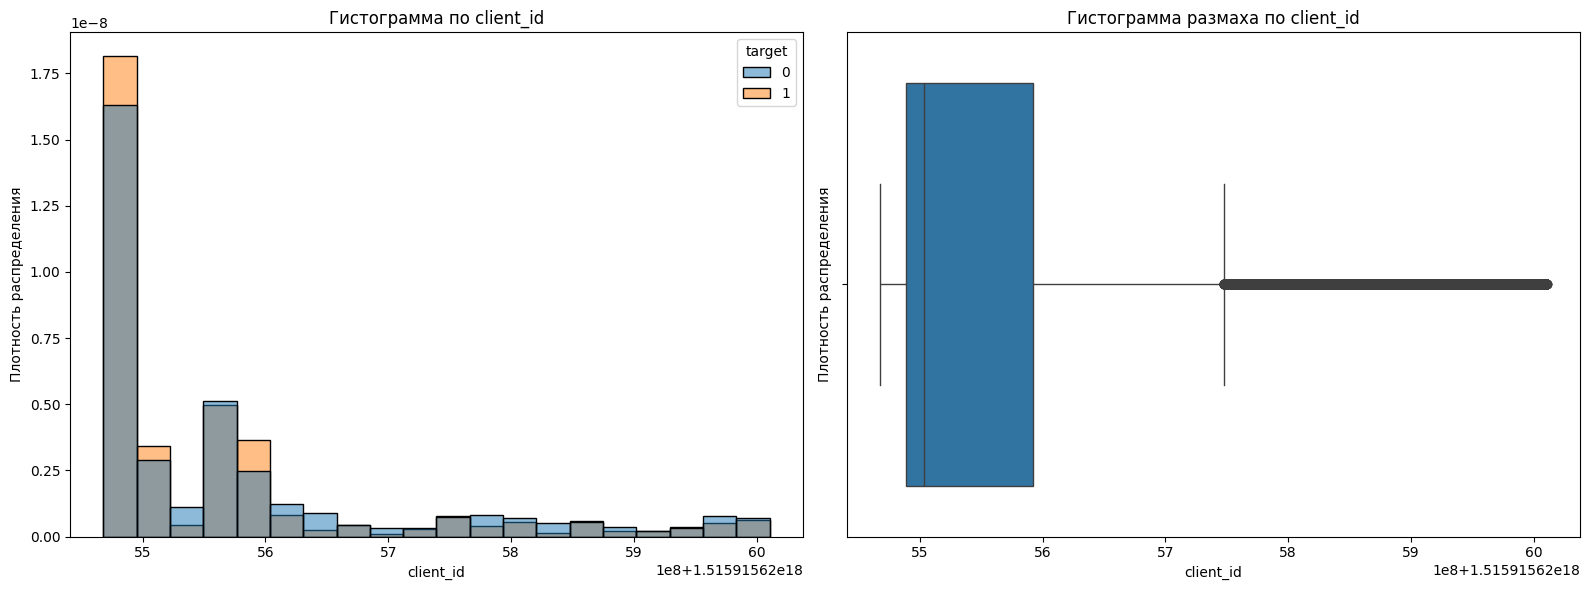

Визуализация числового признака: price


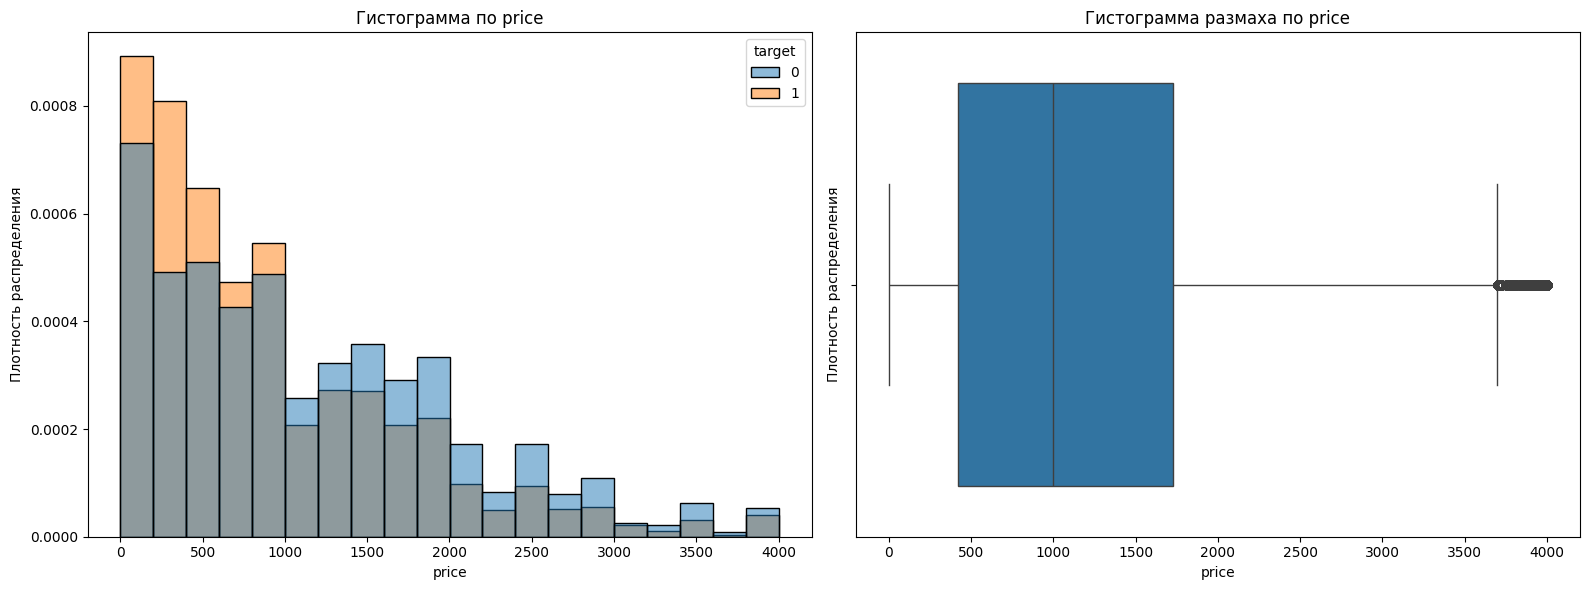

Визуализация числового признака: bulk_campaign_id


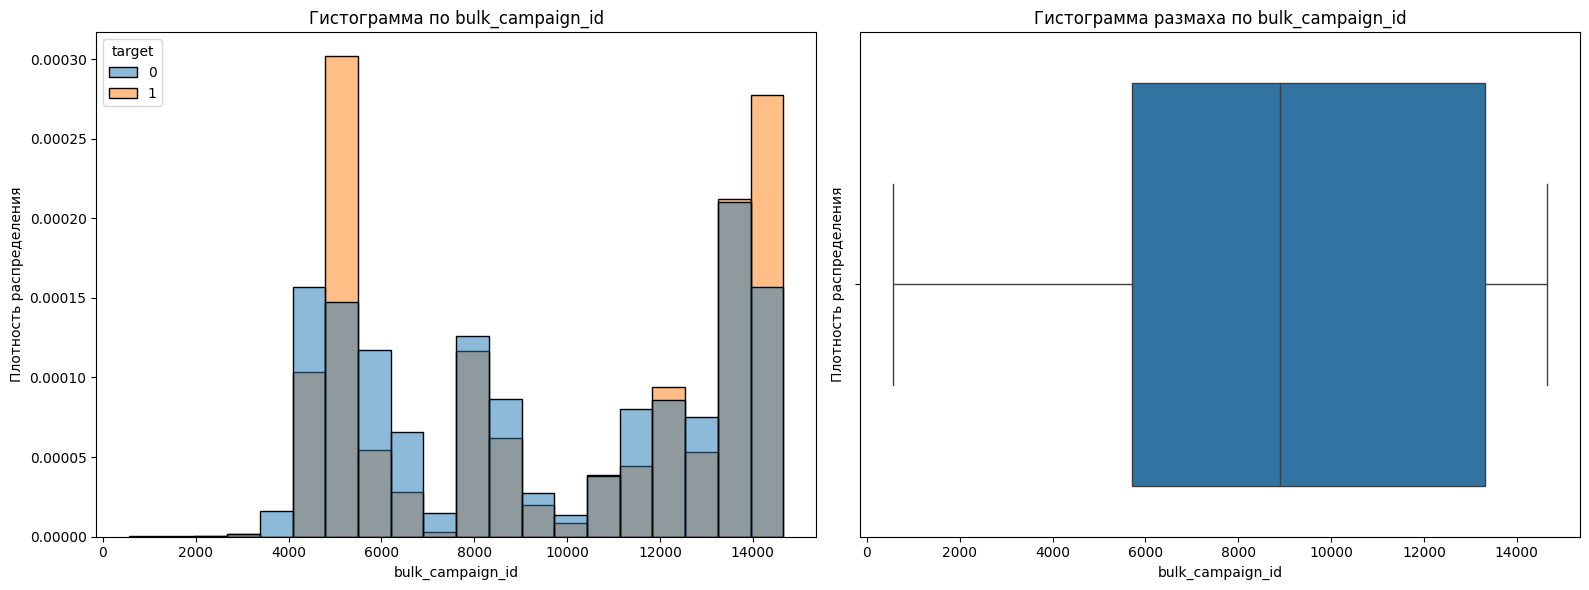

Визуализация числового признака: target


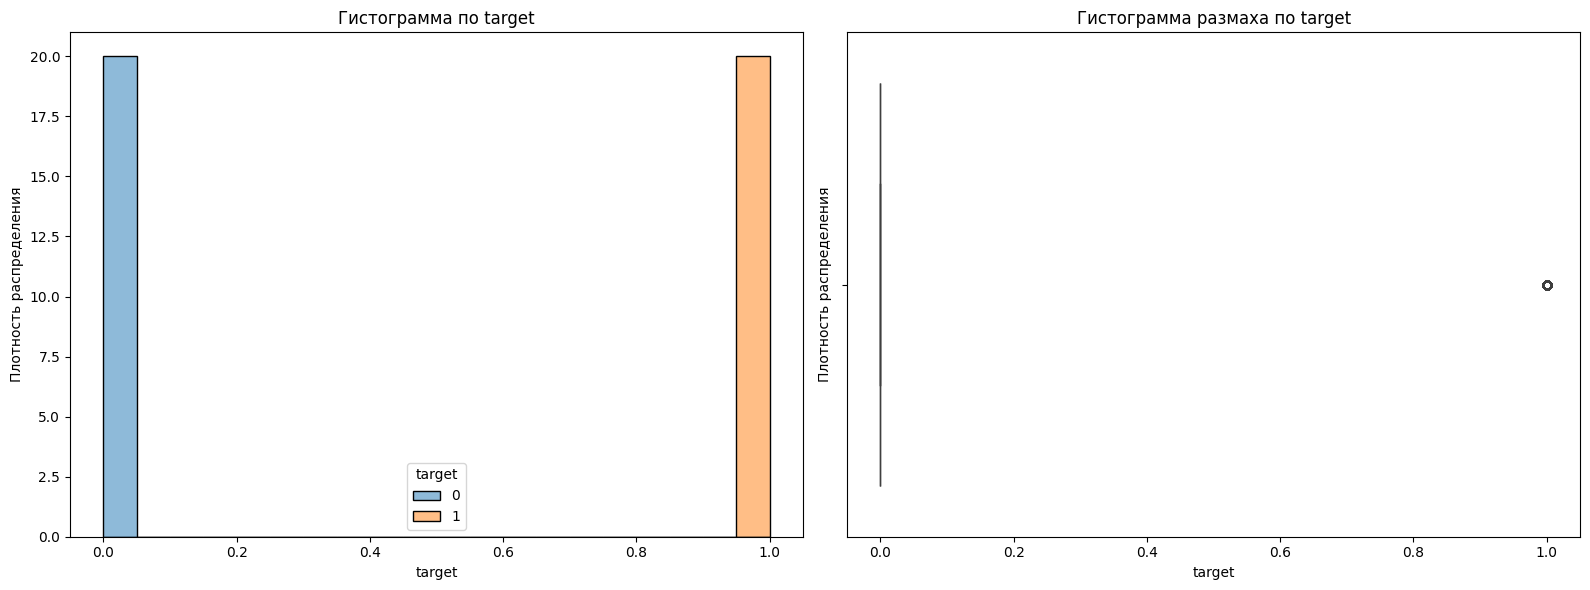

In [35]:
# Визуализируем числовые признаки

all_diag(data_fltr, column_type='numeric', hue='target')

По графику можно сделать вывод о том, что клиенты чаще совершали покупки более дешевых товаров и доля совершенных покупок в более дешевых товарах также больше.

### 2.2 Анализ категориальных признаков

In [36]:
data_fltr.head()

,client_id,price,category_ids,date_buy,message_id,bulk_campaign_id,event,channel,created_at,target
0,1515915625468169594,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,NaN,NaN,NaN,NaT,0
1,1515915625468169594,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,NaN,NaN,NaN,NaT,0
5,1515915625471640575,3499.00,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,NaN,NaN,NaN,NaT,0
6,1515915625490211585,1699.00,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283,NaN,NaN,NaN,NaT,0
7,1515915625490739153,1999.00,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,4172.00,open,email,2022-05-27 07:52:08,0


Перед построением графиков попробуем обработать категориальные признаки.

**category_ids**

category_ids - разобьем на столбцы с категориями, cat_4 cat_27 и так далее, если категория есть - 1, нет - 0.

In [37]:
# Посмотрим тип данных в столбце

type(data_fltr['category_ids'].iloc[0])

str

Строка, а нам нужен список

In [38]:
# Преобразуем строки в списки

data_fltr['category_ids'] = data_fltr['category_ids'].apply(ast.literal_eval)

In [39]:
# Проверим получившийся тип данных

type(data_fltr['category_ids'].iloc[0])

list

Теперь все ок

In [40]:
# Создадим Series со всеми категориями

all_cat = pd.Series([cat for cat_list in data_fltr['category_ids'] for cat in cat_list])

In [41]:
# Посчитаем количество вхождений каждой категории

category_counts = all_cat.value_counts()

In [42]:
# Посмотрим на количество вхождений в первые 100 категорий

category_counts.head(100)

4       298546
28      222022
5562    114309
2        76427
18       68650
         ...  
496       3275
142       3275
500       3224
1848      3146
181       3142
Name: count, Length: 100, dtype: int64

In [43]:
# Возьмем первые 100 категорий

top_100 = set(category_counts.head(100).index)

In [44]:
# Заменим значения категорий которые не вошли в первую сотню на other

data_fltr['category_ids'] = data_fltr['category_ids'].apply(
    lambda cat_list: [cat if cat in top_100 else 'other' for cat in cat_list]
)

In [45]:
# Сделаем словарь из колонок и преобразуем в датафрейм

binary_columns = {
    f'cat_{cat}': data_fltr['category_ids'].apply(lambda row: int(cat in row))
    for cat in top_100
}
binary_data = pd.DataFrame(binary_columns)

In [46]:
# Добавим датасет с новыми колонками в наш датасет

data_cat = pd.concat([data_fltr.reset_index(drop=True), binary_data.reset_index(drop=True)], axis=1)

In [47]:
# Удалим оригинальную колонку

data_cat.drop(columns='category_ids', inplace=True)

In [48]:
# Посмотрим что получилось

data_cat.head()

,client_id,price,date_buy,message_id,bulk_campaign_id,event,channel,created_at,target,cat_287,cat_44,cat_555,cat_421,cat_5608,cat_505,cat_440,cat_329,cat_661,cat_290,cat_340,cat_500,cat_445,cat_58,cat_28,cat_5633,cat_561,cat_5669,cat_1312,cat_344,cat_62,cat_61,cat_181,cat_326,cat_267,cat_441,cat_38,cat_17,cat_726,cat_415,cat_27,cat_466,cat_563,cat_429,cat_310,cat_1431,cat_5548,cat_615,cat_1822,cat_432,cat_673,cat_343,cat_213,cat_124,cat_1828,cat_260,cat_243,cat_29,cat_436,cat_212,cat_422,cat_434,cat_657,cat_2,cat_18,cat_31,cat_57,cat_104,cat_239,cat_5666,cat_274,cat_443,cat_275,cat_413,cat_418,cat_5589,cat_425,cat_417,cat_496,cat_658,cat_5634,cat_420,cat_5537,cat_5630,cat_324,cat_656,cat_5607,cat_5631,cat_218,cat_155,cat_258,cat_49,cat_249,cat_146,cat_5597,cat_142,cat_506,cat_431,cat_5549,cat_6065,cat_4,cat_616,cat_548,cat_5536,cat_6058,cat_1848,cat_6060,cat_5562,cat_244,cat_5632
0,1515915625468169594,1999.00,2022-05-16,1515915625468169594-4301-627b661e9736d,NaN,NaN,NaN,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1515915625468169594,2499.00,2022-05-16,1515915625468169594-4301-627b661e9736d,NaN,NaN,NaN,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,1515915625471640575,3499.00,2022-05-16,1515915625471640575-4301-627b661b67ac3,NaN,NaN,NaN,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1515915625490211585,1699.00,2022-05-16,1515915625490211585-4301-627b661843283,NaN,NaN,NaN,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1515915625490739153,1999.00,2022-05-16,1515915625490739153-4172-626b943cc789b,4172.00,open,email,2022-05-27 07:52:08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**message_id**

message_id - у нас похоже состоит из client_id + bulk_campaign_id и самого message_id, первые 2 значения нам не нужны т.к. есть в отдельных столбцах

In [49]:
# Создадим функцию которая удалит первые 2 числа

def del_2(s):
    if isinstance(s, str):
        parts = s.split('-')
        return '-'.join(parts[2:])
    return s

In [50]:
# Удалим первые 2 числа

data_cat['message_id'] = data_cat['message_id'].apply(del_2)

In [51]:
# Посмотрим что получилось

data_cat.head()

,client_id,price,date_buy,message_id,bulk_campaign_id,event,channel,created_at,target,cat_287,cat_44,cat_555,cat_421,cat_5608,cat_505,cat_440,cat_329,cat_661,cat_290,cat_340,cat_500,cat_445,cat_58,cat_28,cat_5633,cat_561,cat_5669,cat_1312,cat_344,cat_62,cat_61,cat_181,cat_326,cat_267,cat_441,cat_38,cat_17,cat_726,cat_415,cat_27,cat_466,cat_563,cat_429,cat_310,cat_1431,cat_5548,cat_615,cat_1822,cat_432,cat_673,cat_343,cat_213,cat_124,cat_1828,cat_260,cat_243,cat_29,cat_436,cat_212,cat_422,cat_434,cat_657,cat_2,cat_18,cat_31,cat_57,cat_104,cat_239,cat_5666,cat_274,cat_443,cat_275,cat_413,cat_418,cat_5589,cat_425,cat_417,cat_496,cat_658,cat_5634,cat_420,cat_5537,cat_5630,cat_324,cat_656,cat_5607,cat_5631,cat_218,cat_155,cat_258,cat_49,cat_249,cat_146,cat_5597,cat_142,cat_506,cat_431,cat_5549,cat_6065,cat_4,cat_616,cat_548,cat_5536,cat_6058,cat_1848,cat_6060,cat_5562,cat_244,cat_5632
0,1515915625468169594,1999.00,2022-05-16,627b661e9736d,NaN,NaN,NaN,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1515915625468169594,2499.00,2022-05-16,627b661e9736d,NaN,NaN,NaN,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,1515915625471640575,3499.00,2022-05-16,627b661b67ac3,NaN,NaN,NaN,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1515915625490211585,1699.00,2022-05-16,627b661843283,NaN,NaN,NaN,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1515915625490739153,1999.00,2022-05-16,626b943cc789b,4172.00,open,email,2022-05-27 07:52:08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# Посмотрим количество уникальных сообщений на каждого клиента

unique_messages_per_client = data_cat.groupby('client_id')['message_id'].nunique()
unique_messages_per_client.sort_values(ascending=False).head(10)

client_id
1515915625853312319    27
1515915625500232103    15
1515915625860624470    13
1515915625549395201    11
1515915625579040539    11
1515915625536060309    11
1515915625490334876    10
1515915625468073780    10
1515915625470860261    10
1515915625468158647    10
Name: message_id, dtype: int64

In [53]:
# Посмотрим количество уникальных клиентов которым отправлены сообщения с одним id

unique_clients_per_message = data_cat.groupby('message_id')['client_id'].nunique()
unique_clients_per_message.sort_values(ascending=False).head(10)

message_id
6311b13a4cf78    86
645cf0f021e14     5
6167f907da99f     5
64a2c7d7df169     4
6423f117d196e     4
643673f3ce474     4
638a1d904321f     4
64367391179b7     3
6371eb0e83e88     3
63d8cfe9ab4aa     3
Name: client_id, dtype: int64

Не будем добавлять этот признак в обучение модели т.к. мы не знаем каким образов задаются id сообщений, возможно это одинаковые сообщения с разным временем отправки или наоборот совсем разные сообщения.

**bulk_campaign_id**

In [54]:
# Посмотрим количество уникальных рассылок на первых 10 клиентов

unique_compain_per_client = data_cat.groupby('client_id')['bulk_campaign_id'].nunique()
unique_compain_per_client.sort_values(ascending=False).head(10)

client_id
1515915625500232103    14
1515915625579040539    11
1515915625549395201    11
1515915625536060309    11
1515915625470860261    10
1515915625490334876    10
1515915625468159950    10
1515915625468073780     9
1515915625571466103     9
1515915625504202482     9
Name: bulk_campaign_id, dtype: int64

In [55]:
# Посмотрим количество уникальных клиентов на рассылку

unique_clients_per_campaign = data_cat.groupby('bulk_campaign_id')['client_id'].nunique()
unique_clients_per_campaign.sort_values(ascending=False).head(10)

bulk_campaign_id
4679.00     1362
5335.00      894
12218.00     856
7803.00      808
6223.00      713
4492.00      695
4744.00      653
5922.00      631
4710.00      609
11760.00     607
Name: client_id, dtype: int64

Этот признак в обучении модели также не будем использовать. Как мы пойдем далее этот признак при построении модели имеет наибольшую важность, т.е. когда например появится рассылка с новым id - качество нашей модели сильно упадет.

In [56]:
# Визуализируем категориальные признаки

all_diag(data_cat, column_type='categorical', hue='target')

Визуализация категориального признака message_id


NameError: name 'cat_diag' is not defined

- client_id - айди клиентов, очень много уникальных значений - врядли как-то влияет на таргет, думаю этот признак можно удалить
- target - сразу видим дисбаланс классов, всего 3% покупателей совершили покупку
- message_id - айди сообщения, очень много уникальных значений - думаю также не влияет на таргет и можно удалить этот столбец
- bulk_campaign_id - идентификатор рассылки, мы не знаем содердимого рассылок - можно удалить этот столбец
- event - действие с сообщением, больше всего действий приодится на purchase и click, распределние по таргету примерно соответствует распределению по количеству действий
- channel - канал рассылки преимущественно email

### 2.3. Анализ временных признаков

Визуализация верменного признака: date_buy


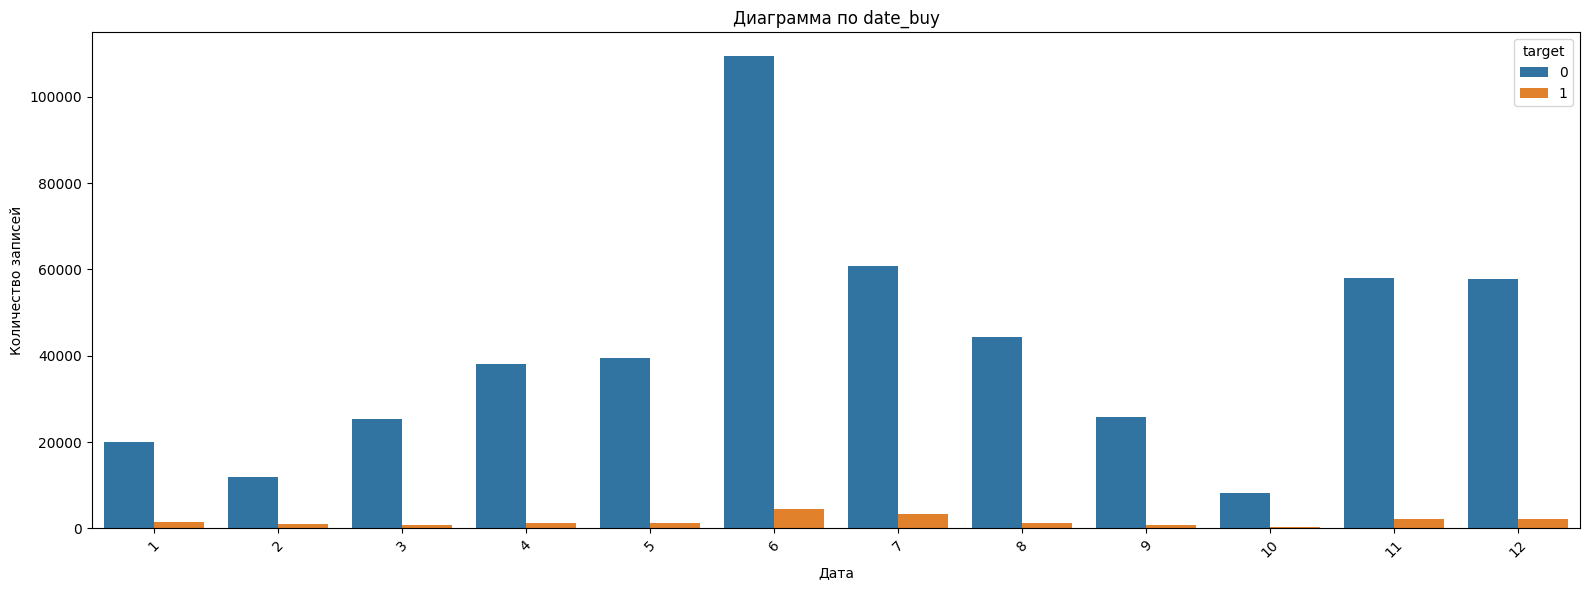

Визуализация верменного признака: created_at


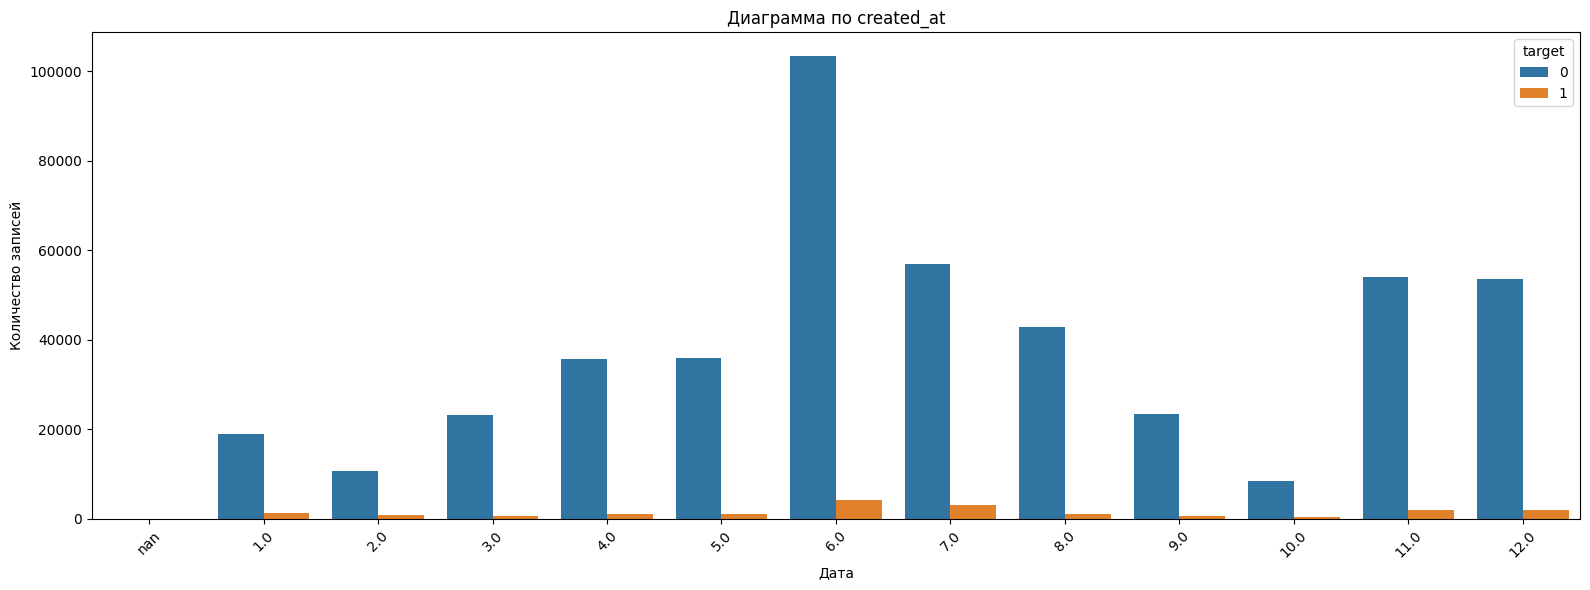

In [141]:
# Визуализируем временные признаки
all_diag(data_cat, column_type='date', hue='target')

In [57]:
# Создадим из временных признаков новые признаки с днем недели и месяцем

for col in ['date_buy', 'created_at']:
    data_cat[f'{col}_dayofweek'] = data_cat[col].dt.dayofweek.astype(str)
    data_cat[f'{col}_month'] = data_cat[col].dt.month.astype(str)

In [58]:
# Удалим начальные столбцы после обработки

data_cat = data_cat.drop(columns=['date_buy', 'created_at'])

In [59]:
# Проверим что получилось

data_cat.head()

,client_id,price,message_id,bulk_campaign_id,event,channel,target,cat_287,cat_44,cat_555,cat_421,cat_5608,cat_505,cat_440,cat_329,cat_661,cat_290,cat_340,cat_500,cat_445,cat_58,cat_28,cat_5633,cat_561,cat_5669,cat_1312,cat_344,cat_62,cat_61,cat_181,cat_326,cat_267,cat_441,cat_38,cat_17,cat_726,cat_415,cat_27,cat_466,cat_563,cat_429,cat_310,cat_1431,cat_5548,cat_615,cat_1822,cat_432,cat_673,cat_343,cat_213,cat_124,cat_1828,cat_260,cat_243,cat_29,cat_436,cat_212,cat_422,cat_434,cat_657,cat_2,cat_18,cat_31,cat_57,cat_104,cat_239,cat_5666,cat_274,cat_443,cat_275,cat_413,cat_418,cat_5589,cat_425,cat_417,cat_496,cat_658,cat_5634,cat_420,cat_5537,cat_5630,cat_324,cat_656,cat_5607,cat_5631,cat_218,cat_155,cat_258,cat_49,cat_249,cat_146,cat_5597,cat_142,cat_506,cat_431,cat_5549,cat_6065,cat_4,cat_616,cat_548,cat_5536,cat_6058,cat_1848,cat_6060,cat_5562,cat_244,cat_5632,date_buy_dayofweek,date_buy_month,created_at_dayofweek,created_at_month
0,1515915625468169594,1999.00,627b661e9736d,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,5,nan,nan
1,1515915625468169594,2499.00,627b661e9736d,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,5,nan,nan
2,1515915625471640575,3499.00,627b661b67ac3,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,nan,nan
3,1515915625490211585,1699.00,627b661843283,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,nan,nan
4,1515915625490739153,1999.00,626b943cc789b,4172.00,open,email,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,4.0,5.0


In [60]:
# Посмотрим на получившийся датасет

overview_data(data_cat)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519035 entries, 0 to 519034
Columns: 111 entries, client_id to created_at_month
dtypes: float64(2), int64(102), object(7)
memory usage: 439.6+ MB
None


--------------------------------------------------
Пропуски
--------------------------------------------------
client_id                   0
price                       0
message_id                  0
bulk_campaign_id        32831
event                   32831
                        ...  
cat_5632                    0
date_buy_dayofweek          0
date_buy_month              0
created_at_dayofweek        0
created_at_month            0
Length: 111, dtype: int64


--------------------------------------------------
Дубликаты
--------------------------------------------------
114905




In [61]:
# Построим график по дням недели

cat_diag(data_cat, 'created_at_dayofweek', 'created_at_dayofweek', hue='target', threshold=0.015)

NameError: name 'cat_diag' is not defined

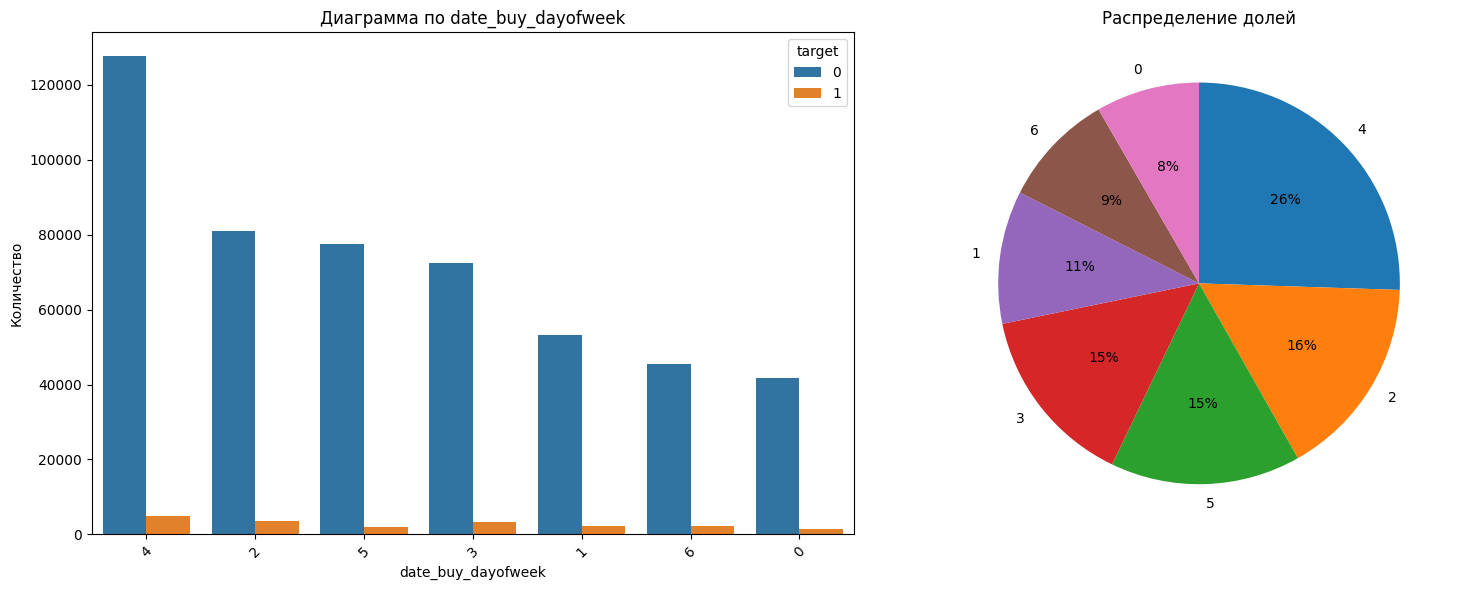

In [148]:
# Построим график по дням недели
cat_diag(data_cat, 'date_buy_dayofweek', 'date_buy_dayofweek', hue='target', threshold=0.015)

Пятница самый активный день для покупок, за ней по активности идут среда и четверг

In [62]:
# Построим график по месяцам

cat_diag(data_cat, 'created_at_month', 'created_at_month', hue='target', threshold=0.015)

NameError: name 'cat_diag' is not defined

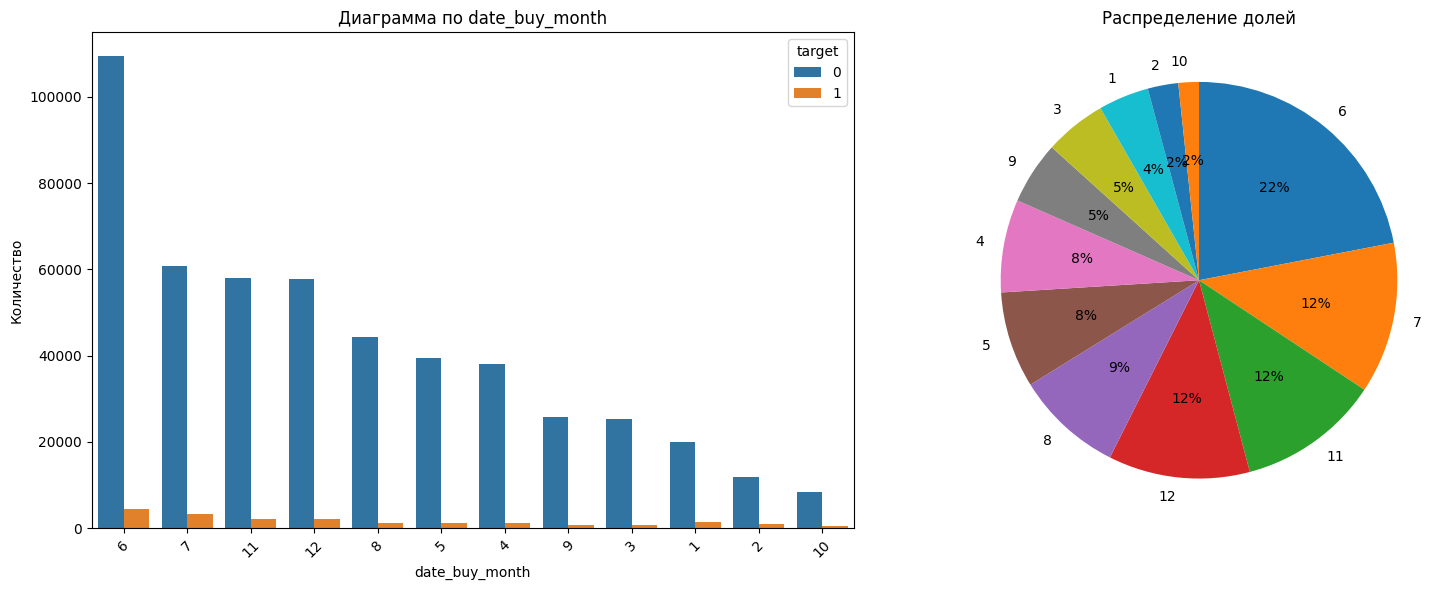

In [150]:
# Построим график по месяцам
cat_diag(data_cat, 'date_buy_month', 'date_buy_month', hue='target', threshold=0.015)

Самые активные месяцы это июнь и ноябрь и декабрь. Ноябрь и декабрь предновогодние месяцы - возможно люди покупают подарки, а летом возможно готовятся к отпуску. Также такое распределение на графике связано с тем, что у нас недостаточно данных за 2024 год, 2022 год также не полный

Диаграммы и распределения долей дат покупок и дат сообщений очень сильно похожи и будут коррелировать между собой. Считаю, что даты покупок для нас более важны, поэтому признаки с датами сообщений удалим. 

In [63]:
# Проверим самую раннюю и самую позднюю дату сообщений

print(data_fltr['created_at'].min())
print(data_fltr['created_at'].max())

2022-05-19 01:50:17
2024-02-15 23:51:20


In [64]:
# Проверим самую раннюю и самую позднюю дату покупок

print(data_fltr['date_buy'].min())
print(data_fltr['date_buy'].max())

2022-05-16 00:00:00
2024-02-16 00:00:00


In [65]:
# Удалим колонки с датами создания сообщений

cols_to_drop = [
    'created_at_dayofweek',
    'created_at_month']

data_cat = data_cat.drop(columns=cols_to_drop)

### Вывод

Числовые признаки:
- Нашли и отфильтровали выбросы по числовым признакам
- По графику price можно сделать вывод о том, что клиенты чаще совершали покупки более дешевых товаров и доля совершенных покупок в более дешевых товарах также больше

Категориальные признаки:
- category_ids выбрали топ 100 популярных категорий
- message_id - у нас похоже состоит из client_id + bulk_campaign_id и самого message_id, первые 2 значения нам не нужны т.к. есть в отдельных столбцах. Не будем добавлять этот признак в обучение модели т.к. мы не знаем каким образом задаются id сообщений, возможно это одинаковые сообщения с разным временем отправки или наоборот совсем разные сообщения. Также этот признак приводит к сильному переобучению модели
- bulk_campaign_id - этот признак в обучении модели также не будем использовать. Как мы пойдем далее этот признак при построении модели имеет наибольшую важность, т.е. когда например появится рассылка с новым id - качество нашей модели сильно упадет
- event - действие с сообщением, больше всего действий приодится на purchase и click, распределние по таргету примерно соответствует распределению по количеству действий
- channel - канал рассылки преимущественно email

Временные признаки:
- Создали новые признаки - день недели и месяц покупки. Это может быть связанно с сезонностью. Признак создания сообщения удалили т.к. он сильно коррелирует с днем покупки.

## 3. Корреляционный анализ

### 3.1. Матрица корреляций

In [66]:
# Скопируем и удалим неинформативные признаки и признаки начинающиеся на cat_

data_corr = data_cat.copy()
data_corr = data_cat.drop(columns=[
    'client_id', 'message_id', 'bulk_campaign_id',
    *[col for col in data_cat.columns if col.startswith('cat')]
])

In [67]:
# Посмотрим на информацию о датасете

data_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519035 entries, 0 to 519034
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               519035 non-null  float64
 1   event               486204 non-null  object 
 2   channel             486204 non-null  object 
 3   target              519035 non-null  int64  
 4   date_buy_dayofweek  519035 non-null  object 
 5   date_buy_month      519035 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 23.8+ MB


In [68]:
# Вычислим матрицу Phik для нашего датасета

phk = data_corr.phik_matrix(verbose=False, interval_cols=['price'])

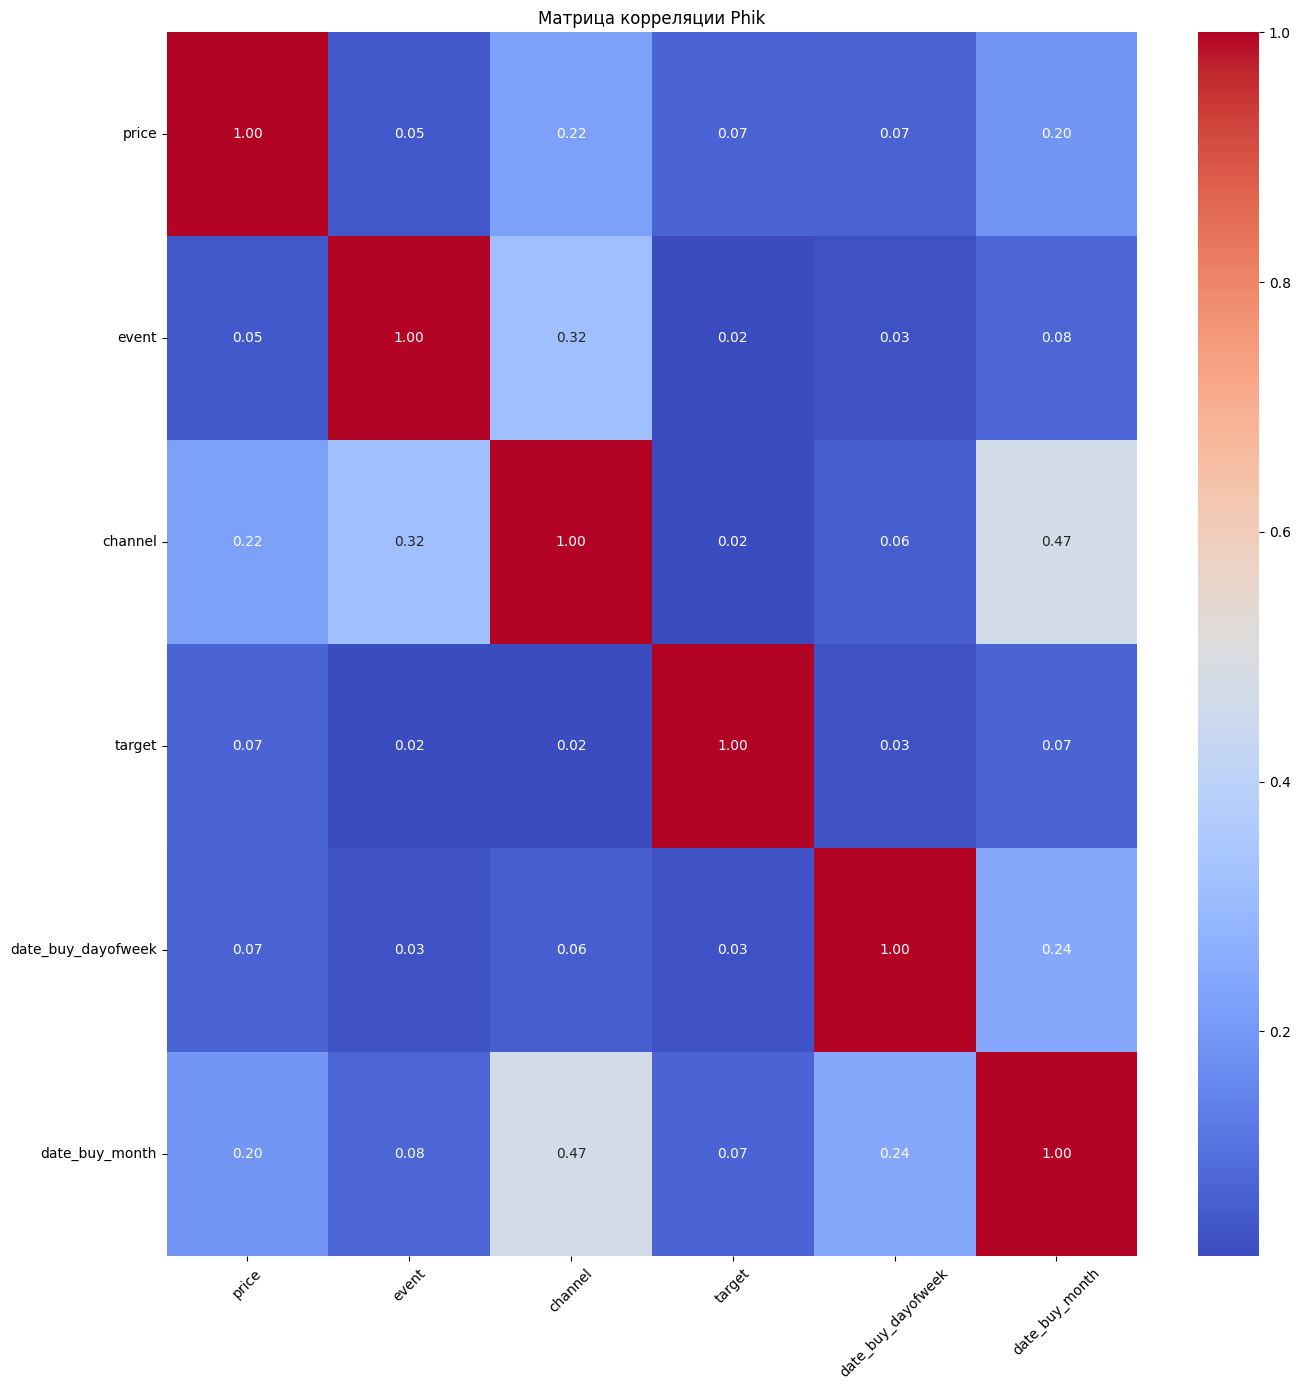

In [69]:
# Визуализируем матрицу корреляции

plt.figure(figsize=(14, 14))
plt.title('Матрица корреляции Phik')
sns.heatmap(phk, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- Сильной корреляции с целевым признаком target нет
- Корреляции между признаками:
	- channel - date_buy_month: 0.47 - Возможно, разные каналы активны в разные месяцы.
	- event - channel: 0.31 - Возможно, определённые события проводятся через определённые каналы.
	- channel - price: 0.21 - Канал влияет на стоимость покупки.

Теперь проанализируем признаки с категориями покупок. Матрицу корреляций построим только для первых 20 иначе будет ничего не видно.

In [70]:
# Выберем 20 колонок с категорями

data_cat.columns[7:107]

Index(['cat_287', 'cat_44', 'cat_555', 'cat_421', 'cat_5608', 'cat_505',
       'cat_440', 'cat_329', 'cat_661', 'cat_290', 'cat_340', 'cat_500',
       'cat_445', 'cat_58', 'cat_28', 'cat_5633', 'cat_561', 'cat_5669',
       'cat_1312', 'cat_344', 'cat_62', 'cat_61', 'cat_181', 'cat_326',
       'cat_267', 'cat_441', 'cat_38', 'cat_17', 'cat_726', 'cat_415',
       'cat_27', 'cat_466', 'cat_563', 'cat_429', 'cat_310', 'cat_1431',
       'cat_5548', 'cat_615', 'cat_1822', 'cat_432', 'cat_673', 'cat_343',
       'cat_213', 'cat_124', 'cat_1828', 'cat_260', 'cat_243', 'cat_29',
       'cat_436', 'cat_212', 'cat_422', 'cat_434', 'cat_657', 'cat_2',
       'cat_18', 'cat_31', 'cat_57', 'cat_104', 'cat_239', 'cat_5666',
       'cat_274', 'cat_443', 'cat_275', 'cat_413', 'cat_418', 'cat_5589',
       'cat_425', 'cat_417', 'cat_496', 'cat_658', 'cat_5634', 'cat_420',
       'cat_5537', 'cat_5630', 'cat_324', 'cat_656', 'cat_5607', 'cat_5631',
       'cat_218', 'cat_155', 'cat_258', 'cat_49', 

In [71]:
# Колонки с категориями для матрицы корреляций

cols = ['target'] + list(data_cat.columns[7:27])

<Axes: >

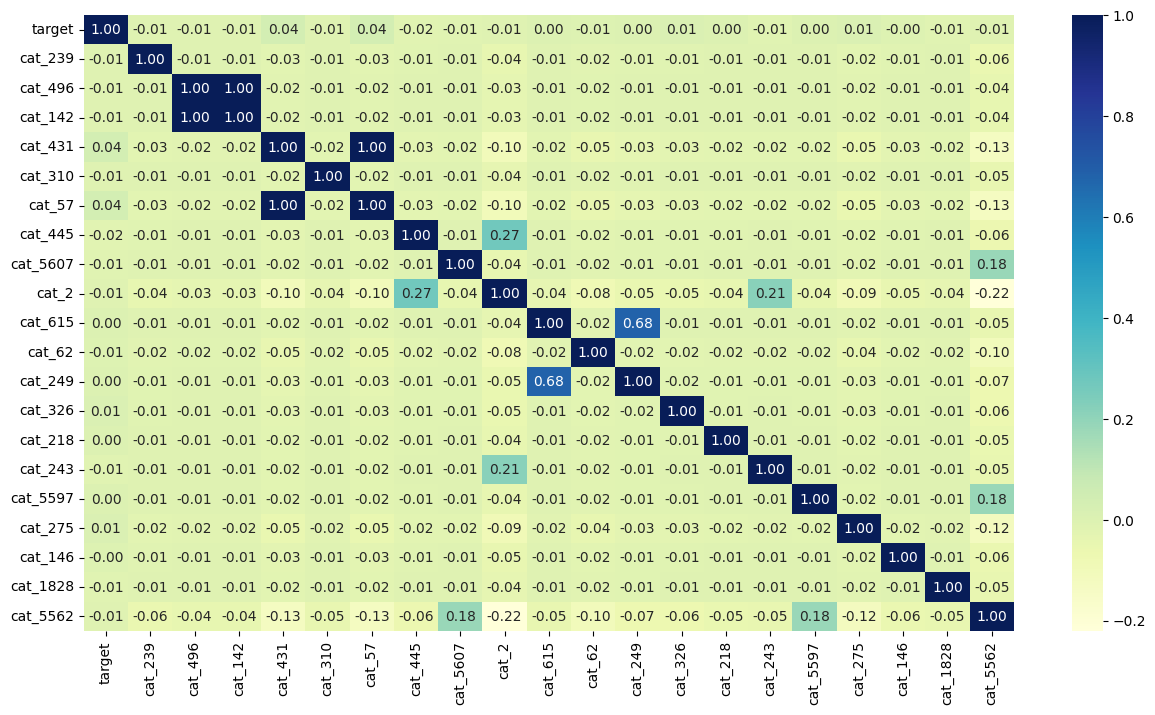

In [160]:
# Посмотрим на корреляцию с тегами
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(data_cat[cols].corr(), annot=True, fmt='.2f', cmap='YlGnBu')

Все категории имеют слабые корреляции с таргетом но коррелируют между собой. Сначала отберем признаки имеющие корреляцию с таргетом более 1%.

In [72]:
# Отфильтруем признаки - оставим только те, у которых величина корреляции с целевым больше 1%

cols_to_train = []
corrs = []

numeric_cols = data_cat.columns[7:107]

for col in numeric_cols:
    cor = data_cat['target'].corr(data_cat[col])
    if abs(cor) >= 0.01:
        cols_to_train.append(col)
        corrs.append(cor)

print("columns_to_train =", len(cols_to_train))

cols_stats = pd.DataFrame({
    'col': cols_to_train,
    'corr': corrs
}).sort_values(by='corr', ascending=False)

cols_stats

columns_to_train = 29


,col,corr
22,cat_155,0.04
24,cat_431,0.04
18,cat_57,0.04
8,cat_726,0.03
16,cat_422,0.02
15,cat_212,0.02
0,cat_287,0.02
26,cat_4,0.02
10,cat_27,0.01
3,cat_290,0.01


Отобрали 29 колонок

Соединим датасет с отобранными колонками категорий

In [73]:
# Список признаков без категорий

cols_from_corr = list(data_corr.columns)

In [74]:
# Отобранные признаки категорий и список признаков без категорий

final_features = cols_to_train + cols_from_corr + ['client_id']

In [75]:
# Создадим финальный датасет

data_final = data_cat[final_features]

In [76]:
# Посмотрим что получилось

data_final.head()

,cat_287,cat_505,cat_440,cat_290,cat_445,cat_344,cat_326,cat_441,cat_726,cat_415,cat_27,cat_432,cat_124,cat_1828,cat_243,cat_212,cat_422,cat_31,cat_57,cat_5630,cat_5607,cat_5631,cat_155,cat_258,cat_431,cat_5549,cat_4,cat_244,cat_5632,price,event,channel,target,date_buy_dayofweek,date_buy_month,client_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1999.00,NaN,NaN,0,0,5,1515915625468169594
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,2499.00,NaN,NaN,0,0,5,1515915625468169594
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3499.00,NaN,NaN,0,0,5,1515915625471640575
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1699.00,NaN,NaN,0,0,5,1515915625490211585
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999.00,open,email,0,0,5,1515915625490739153


In [167]:
# Посмотрим на получившийся датасет
overview_data(data_final)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519035 entries, 0 to 519034
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   cat_431             519035 non-null  int64  
 1   cat_57              519035 non-null  int64  
 2   cat_445             519035 non-null  int64  
 3   cat_5607            519035 non-null  int64  
 4   cat_326             519035 non-null  int64  
 5   cat_243             519035 non-null  int64  
 6   cat_1828            519035 non-null  int64  
 7   cat_415             519035 non-null  int64  
 8   cat_505             519035 non-null  int64  
 9   cat_5630            519035 non-null  int64  
 10  cat_440             519035 non-null  int64  
 11  cat_5632            519035 non-null  int64  
 12  cat_31              519035 non-null  int64  
 13  cat_290             519035 

### 3.2. Мультиколлениарность

In [77]:
# Добавим константу

data_const = data_final.select_dtypes(include='number')
data_const = add_constant(data_const)
data_const = data_const.drop(['target', 'client_id'], axis=1)

In [78]:
data_const.head()

,const,cat_287,cat_505,cat_440,cat_290,cat_445,cat_344,cat_326,cat_441,cat_726,cat_415,cat_27,cat_432,cat_124,cat_1828,cat_243,cat_212,cat_422,cat_31,cat_57,cat_5630,cat_5607,cat_5631,cat_155,cat_258,cat_431,cat_5549,cat_4,cat_244,cat_5632,price
0,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1999.00
1,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,2499.00
2,1.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3499.00
3,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1699.00
4,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999.00


In [79]:
def calc_vif(data):
    """
    Вычисляет коэффициенты VIF для признаков

    Используется для оценки мультиколлинеарности между числовыми признаками.

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица с числовыми признаками без пропусков

    Возвращает
    ----------
    pandas.DataFrame
        Таблица с двумя столбцами:
        - 'variables' — названия признаков
        - 'VIF' — значения VIF
    """
    
    
    vif_data = pd.DataFrame()
    vif_data['variables'] = data.columns
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    
    return vif_data

In [80]:
# Рассчитаем VIF

data_const = data_const.dropna()
calc_vif(data_const)

/home/komap/tf-gpu/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,const,5.03
1,cat_287,1.18
2,cat_505,inf
3,cat_440,inf
4,cat_290,2.65
5,cat_445,inf
6,cat_344,inf
7,cat_326,inf
8,cat_441,3.31
9,cat_726,2.55


Признаки с высоким VIF (мультиколлинеарность):
cat_18, cat_2

Признаки с бесконечным VIF (inf):

cat_244, cat_440, cat_432, cat_243, cat_445, cat_505, cat_329, cat_344, cat_329, cat_506

In [81]:
# Создадим список с бесконечным и высоким VIF

cat_del = ['cat_124', 'cat_415', 'cat_244', 'cat_431', 'cat_432', 'cat_344', 'cat_57', 'cat_505', 'cat_445', 'cat_326', 'cat_243', 'cat_440']

In [82]:
# Удалим эти признаки из датасета

data_clean = data_final.drop(columns=cat_del)

### Вывод

- Сильной корреляции с целевым признаком target нет
- Корреляции между признаками:
	- channel - date_buy_month: 0.47 - Возможно, разные каналы активны в разные месяцы.
	- event - channel: 0.31 - Возможно, определённые события проводятся через определённые каналы.
	- channel - price: 0.21 - Канал влияет на стоимость покупки.

- Все категории имеют слабые корреляции с таргетом но коррелируют между собой. Отобрали признаки имеющие корреляцию с таргетом более 1%.
- Удалили признаки с бесконечным и высоким VIF

## 4. Обучение моделей

### 4.1. Подготовка данных

In [83]:
# Посмотрим на получившийся датасет

data_clean.head()

,cat_287,cat_290,cat_441,cat_726,cat_27,cat_1828,cat_212,cat_422,cat_31,cat_5630,cat_5607,cat_5631,cat_155,cat_258,cat_5549,cat_4,cat_5632,price,event,channel,target,date_buy_dayofweek,date_buy_month,client_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1999.00,NaN,NaN,0,0,5,1515915625468169594
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2499.00,NaN,NaN,0,0,5,1515915625468169594
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3499.00,NaN,NaN,0,0,5,1515915625471640575
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1699.00,NaN,NaN,0,0,5,1515915625490211585
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999.00,open,email,0,0,5,1515915625490739153


In [84]:
overview_data(data_clean)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519035 entries, 0 to 519034
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   cat_287             519035 non-null  int64  
 1   cat_290             519035 non-null  int64  
 2   cat_441             519035 non-null  int64  
 3   cat_726             519035 non-null  int64  
 4   cat_27              519035 non-null  int64  
 5   cat_1828            519035 non-null  int64  
 6   cat_212             519035 non-null  int64  
 7   cat_422             519035 non-null  int64  
 8   cat_31              519035 non-null  int64  
 9   cat_5630            519035 non-null  int64  
 10  cat_5607            519035 non-null  int64  
 11  cat_5631            519035 non-null  int64  
 12  cat_155             519035 non-null  int64  
 13  cat_258             519035 

In [85]:
# Создадим копию датасета

data_complete = data_clean.copy()

In [86]:
data_complete = data_complete.drop_duplicates()

In [87]:
data_complete.head()

,cat_287,cat_290,cat_441,cat_726,cat_27,cat_1828,cat_212,cat_422,cat_31,cat_5630,cat_5607,cat_5631,cat_155,cat_258,cat_5549,cat_4,cat_5632,price,event,channel,target,date_buy_dayofweek,date_buy_month,client_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1999.00,NaN,NaN,0,0,5,1515915625468169594
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2499.00,NaN,NaN,0,0,5,1515915625468169594
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3499.00,NaN,NaN,0,0,5,1515915625471640575
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1699.00,NaN,NaN,0,0,5,1515915625490211585
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1999.00,open,email,0,0,5,1515915625490739153


In [88]:
# Определим числовые, категориальные колонки, бинарные колонки

bin_features = [col for col in data_complete.columns if col.startswith('cat_')]
cat_features = ['event', 'channel', 'date_buy_dayofweek', 'date_buy_month']
num_features = ['price']

In [89]:
# Заполним пропуски в event и channel значением other

data_complete[cat_features] = data_complete[cat_features].astype(str).fillna('other')

In [90]:
# Отделим целевой признак от обучающей выборки

X = data_complete.drop(columns='target')
y = data_complete['target']

In [91]:
# Разделим датасет на тренировочные и тестовые данные

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

### 4.2. Пайплайн и обучение

In [92]:
# Создадим трансформер для числовых признаков

num_encoder = Pipeline(steps=[
    ('encoder', StandardScaler())
])

In [93]:
# Создадим трансформер для категориальных признаков

cat_encoder = Pipeline(steps=[
    ('encoder', TargetEncoder())
])

In [94]:
# Создадим общий трансформер для линейных моделей

lin_preprocessor = ColumnTransformer(transformers=[
    ('num', num_encoder, num_features),
    ('cat', cat_encoder, cat_features),
    ('bin', 'passthrough', bin_features)
])

In [95]:
# Создадим общий трансформер для бустингов

lgbm_preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_features),
    ('cat', cat_encoder, cat_features),
    ('bin', 'passthrough', bin_features)
])

In [96]:
# Создадим пайплайн для логистической регрессии

pipe = Pipeline(steps=[
    ('preprocessor', lin_preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [ ]:
# Параметры логистической регрессии для перебора

param_grid_log = [
    {
        'preprocessor': [lin_preprocessor],
        'classifier': [LogisticRegression(class_weight='balanced', max_iter=1000)],
        'classifier__C': [0.01, 0.1, 1, 10]
    }
]

In [98]:
# Параметры LGBMClassifier

param_grid_lgbm = [
    {
        'preprocessor': [lgbm_preprocessor],
        'classifier': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', verbose=-1)],
        'classifier__n_estimators': [100, 300],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [5, 10]
    }
]

In [99]:
# Параметры CatBoostClassifier

param_grid_cat = [
    {
        'preprocessor': ['passthrough'],
        'classifier': [CatBoostClassifier(random_state=RANDOM_STATE, cat_features=cat_features, verbose=0, auto_class_weights='Balanced')],
        'classifier__iterations': [100, 300]
    },
]

In [100]:
%%time
# Обучим GridSearchCV с LogisticRegression
grid_log = GridSearchCV(pipe, param_grid_log, scoring='roc_auc', cv=3, error_score='raise', n_jobs=-1)
grid_log.fit(X_train, y_train)

CPU times: user 11.8 s, sys: 15.9 s, total: 27.7 s
Wall time: 9.35 s


,estimator,Pipeline(step...'balanced'))])
,param_grid,"[{'classifier': [LogisticRegre...max_iter=1000)], 'classifier__C': [0.01, 0.1, ...], 'preprocessor': [ColumnTransfo...'cat_5632'])])]}]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...), ...]"


In [101]:
%%time
# Обучим GridSearchCV с LGBMClassifier
grid_lgbm = GridSearchCV(pipe, param_grid_lgbm, scoring='roc_auc', cv=3, error_score='raise', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

/home/komap/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/komap/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/komap/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/komap/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/komap/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/koma

CPU times: user 14.1 s, sys: 2 s, total: 16.1 s
Wall time: 31min 56s


,estimator,Pipeline(step...'balanced'))])
,param_grid,"[{'classifier': [LGBMClassifie...2, verbose=-1)], 'classifier__learning_rate': [0.05, 0.1], 'classifier__max_depth': [5, 10], 'classifier__n_estimators': [100, 300], ...}]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...), ...]"


In [102]:
%%time
# Обучим GridSearchCV с CatBoostClassifier
grid_cat = GridSearchCV(pipe, param_grid_cat, scoring='roc_auc', cv=3, error_score='raise', n_jobs=-1)
grid_cat.fit(X_train, y_train)

CPU times: user 2min 28s, sys: 1min 16s, total: 3min 45s
Wall time: 1min 4s


,estimator,Pipeline(step...'balanced'))])
,param_grid,"[{'classifier': [<catboost.cor...x7bfb78d01ff0>], 'classifier__iterations': [100, 300], 'preprocessor': ['passthrough']}]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False


In [103]:
# Сохраним обученные GridSearchCV  в словарь

grids = {'logreg': grid_log, 'lgbm': grid_lgbm, 'catboost': grid_cat}

### 4.3. Метрики модели

In [104]:
# Сохраним метрики моделей

results = {}

for name, grid in grids.items():
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        'params': grid.best_params_,
        'roc_auc': roc_auc,
        'classification_report': report,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

/home/komap/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/komap/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [105]:
# Метрики

for name, res in results.items():
    print(f"model: {name}")
    print(f"best params: {res['params']}")
    print(f"roc_auc: {res['roc_auc']:.4f}")
    print("classification_report:")
    print(classification_report(y_test, res['y_pred']))
    print("=" * 60)

model: logreg
best params: {'classifier': LogisticRegression(class_weight='balanced', max_iter=1000), 'classifier__C': 10, 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('encoder',
                                                  StandardScaler())]),
                                 ['price']),
                                ('cat',
                                 Pipeline(steps=[('encoder', TargetEncoder())]),
                                 ['event', 'channel', 'date_buy_dayofweek',
                                  'date_buy_month']),
                                ('bin', 'passthrough',
                                 ['cat_287', 'cat_290', 'cat_441', 'cat_726',
                                  'cat_27', 'cat_1828', 'cat_212', 'cat_422',
                                  'cat_31', 'cat_5630', 'cat_5607', 'cat_5631',
                                  'cat_155', 'cat_258', 'cat_5549', 'cat_4',
                         

CatBoost показал наилучший результат с ROC AUC = 0.8712, следом — LGBM с ROC AUC = 0.8439. Логистическая регрессия ROC AUC = 0.6469.

При выборе метрики мы ориентировались на максимизацию recall, поскольку по моему мнению цель модели — определить пользователей, совершивших покупку, чтобы в дальнейшем можно было предложить им например персональные акции или скидки или как-то по другому мотивировать их совершить новые покупки. Думаю пропуск реальных покупателей может привести к упущенной выгоде и финансовым потерям, а если мы захватим часть людей не совершавших покупки - мы ничего не потеряем.

### 4.4. Важность признаков

Оценим только важность признаков CatBoost и LGBM т.к. логистическая регресссия показала плохие результаты.

In [108]:
# Сохраним лучший пайплайн и лучшую модель

best_pipe_lgbm = grid_lgbm.best_estimator_
best_pipe_cat = grid_cat.best_estimator_
model_lgbm = best_pipe_lgbm.named_steps['classifier']
model_cat = best_pipe_cat.named_steps['classifier']

In [109]:
# Определим explainer

explainer_lgbm = shap.Explainer(model_lgbm)
explainer_cat = shap.Explainer(model_cat)

In [110]:
# Преобразуем X_test

X_test_lgbm = best_pipe_lgbm.named_steps['preprocessor'].transform(X_test)

In [111]:
# Превратим в DataFrame

feature_names = best_pipe_lgbm.named_steps['preprocessor'].get_feature_names_out()
X_test_lgbm = pd.DataFrame(X_test_lgbm, columns=feature_names)

In [112]:
# Получим SHAP значения

shap_values_lgbm = explainer_lgbm(X_test_lgbm)
shap_values_cat = explainer_cat(X_test)

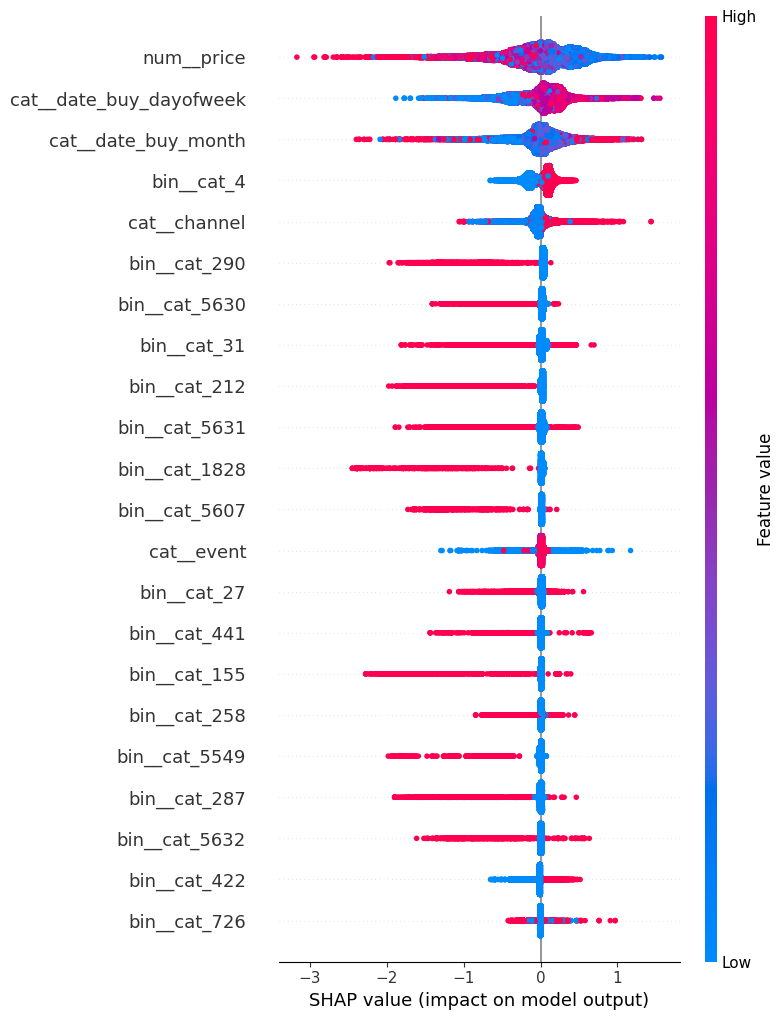

In [113]:
 # Визуализируем beeswarm-график для SHAP значений для LGBM

shap.summary_plot(shap_values_lgbm.values, X_test_lgbm, max_display=300)

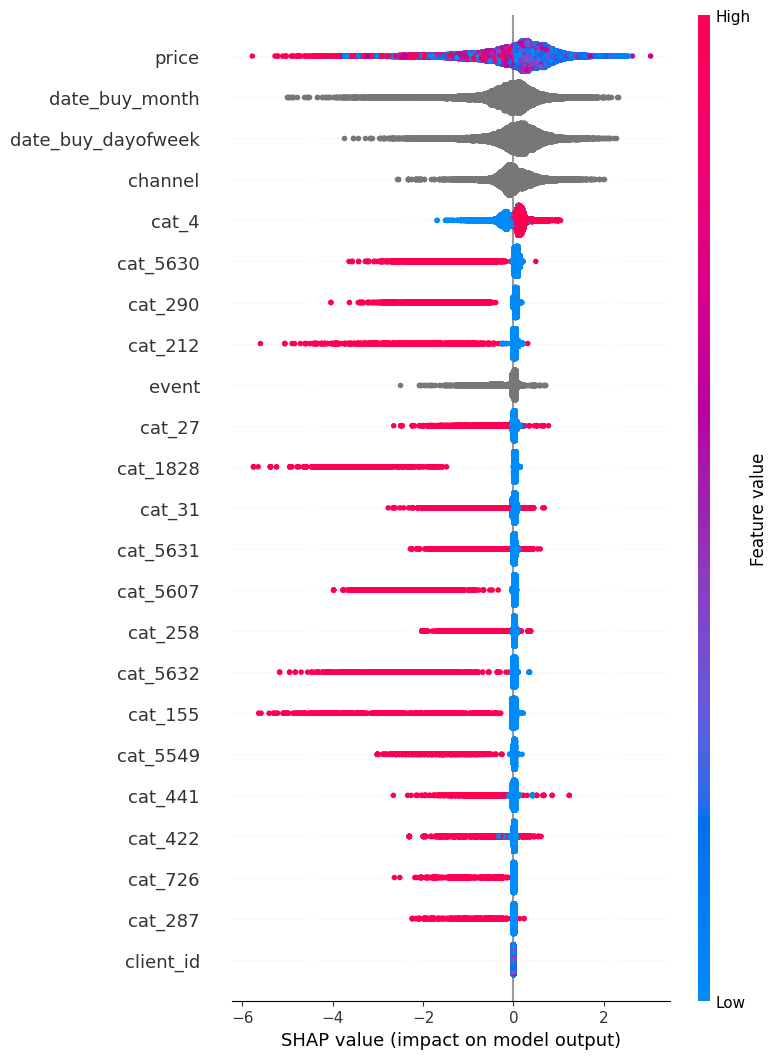

In [114]:
 # Визуализируем beeswarm-график для SHAP значений для CatBoost

shap.summary_plot(shap_values_cat.values, X_test, max_display=300)

Обе модели считают наиболее значимыми:
- price - чем ниже цена, тем выше вероятность покупки
- date_buy_dayofweek - день недели влияет на поведение клиента, возможно в виходные лучше покупают
- date_buy_month - месяц также вносит вклад (возможно сезонность)
- cat_4, cat_5340 - может быть какие-то товары первой необходимости
- chanel, event - возможно текст рассылок как-то влияет на покупку

## Общий вывод

**Цель проекта**
    
- Разработать модель машинного обучения, способную предсказывать вероятность того, что пользователь совершит покупку в течение ближайших 90 дней. Это необходимо для таргетированных маркетинговых кампаний — чтобы предлагать скидки и акции тем, кто с высокой вероятностью заинтересован в продукте.

**Исходные данные**

Использовали 3 датасета:

- apparel-purchases — история покупок, категории товаров, цены, даты
- apparel-messages — информация о рассылках: события, каналы, дата
- target — факт покупки в целевом периоде

Особенности:

- Признак категорий покупок представлен в виде списков
- Наблюдается дисбаланс классов.

**Предобработка и генерация признаков**
  
- Выполнено объединение таблиц по client_id и message_id.
- Извлечены признаки из даты (день недели, месяц, год, время суток)
- Преобразованы категориальные признаки с использованием TargetEncoder
- Проведена очистка и масштабирование числовых признаков.


**Построение моделей и сравнение**

Обучено три модели:

- CatBoost: ROC AUC = 0.8712
- LGBM: ROC AUC = 0.8439
- Logistic Regression: ROC AUC = 0.6469

Модели обучались с использованием Pipeline и GridSearchCV по метрике ROC AUC

**Выбор метрики**

Моя цель — не упустить пользователей, готовых к покупке. Поэтому приоритет отдан recall — важно захватить как можно больше потенциальных покупателей, даже ценой ложных срабатываний (false positives). Пропущенные покупки ведут к потерянной прибыли, тогда как избыточные предложения маловероятно нанесут ущерб.


**SHAP-анализ важности признаков**

- Наиболее значимыми признаками стали: price, dayofweek, month, а также категории cat_5630, cat_4, channel, event
- Обе модели (LGBM и CatBoost) выделили почти одни признаки как важные


**Выводы**

- CatBoostClassifier показал лучшие результаты, но обучался дольше других моделей
- LGBM — достойная альтернатива, результат немного хуже но модель обучилась намного быстрее CatBoost
- Логистическая регрессия — существенно отстала по качеству